In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time

In [3]:
url = 'https://indodax.com'

In [4]:
def get_pairs() :
    return requests.get(url + '/api/pairs').json()

In [5]:
def get_ticker(pairid, timeframe, timefrom, timeto) :
    return requests.get(url + '/tradingview/history_v2?from=' + str(timefrom) + '&symbol=' + pairid +'&tf=' + timeframe + '&to=' + str(timeto)).json()

In [6]:
def show_chart(df, tickername) :
    plt.figure(figsize=(14, 7))
    plt.plot(df['Date'], df['Close'], label=tickername+'/BTC')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (BTC)')
    plt.title('Pergerakan Harga ' + tickername + ' terhadap BTC')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
def get_history_btc_pair(tickername, timeframe, timefrom, timeto, dfbtcidr) :
    ticker_name_low = tickername.lower()
    ticker_name = get_ticker(tickername + 'IDR', timeframe, timefrom, timeto)
    df = pd.DataFrame(ticker_name)
    df['Date'] = pd.to_datetime(df['Time'], unit='s')
    df = df.sort_values(by='Date')

    df_merged = pd.merge(df, dfbtcidr, on='Date', suffixes=('_'+ticker_name_low, '_btc'))
    df_merged['Open_' + ticker_name_low +'_btc'] = df_merged['Open_' + ticker_name_low] / df_merged['Open_btc']
    df_merged['High_' + ticker_name_low +'_btc'] = df_merged['High_' + ticker_name_low] / df_merged['High_btc']
    df_merged['Low_' + ticker_name_low + '_btc'] = df_merged['Low_' + ticker_name_low] / df_merged['Low_btc']
    df_merged['Close_'+ ticker_name_low +'_btc'] = df_merged['Close_' + ticker_name_low] / df_merged['Close_btc']

    df_final = df_merged[['Date', 'Open_' + ticker_name_low +'_btc', 'High_' + ticker_name_low +'_btc', 'Low_' + ticker_name_low + '_btc', 'Close_' + ticker_name_low +'_btc']].copy()
    df_final.rename(columns={
        'Open_' + ticker_name_low +'_btc': 'Open',
        'High_' + ticker_name_low +'_btc': 'High',
        'Low_' + ticker_name_low + '_btc': 'Low',
        'Close_' + ticker_name_low +'_btc': 'Close'
    }, inplace=True)

    return df_final

In [8]:
pairs = get_pairs()
symbols = [item['symbol'] for item in pairs if 'symbol' in item and item['symbol'].endswith('IDR') and item['symbol'] != 'BTCIDR']
print(symbols)

['1INCHIDR', 'AAVEIDR', 'AAIDR', 'AAZIDR', 'ABBCIDR', 'ABIIDR', 'ABYSSIDR', 'ACHIDR', 'ACTIDR', 'ACTSOLIDR', 'ADAIDR', 'ADPIDR', 'AEROIDR', 'AEVOIDR', 'AGIIDR', 'AIIDR', 'AIOZIDR', 'ALICEIDR', 'ALIFIDR', 'ALGOIDR', 'ALPACAIDR', 'ALTLAYERIDR', 'ALTIDR', 'AMPIDR', 'ANDYIDR', 'ANKRIDR', 'AOAIDR', 'APEIDR', 'API3IDR', 'APUIDR', 'ARBIDR', 'ARKMIDR', 'ASIXV2IDR', 'ATAIDR', 'ATHIDR', 'ATOMIDR', 'ATTIDR', 'AUCTIONIDR', 'AUDIOIDR', 'AVAXIDR', 'AXLIDR', 'AXSIDR', 'BADGERIDR', 'BAKEIDR', 'BALIDR', 'BANANAIDR', 'BANDIDR', 'BATIDR', 'BCDIDR', 'BCHIDR', 'BEAMIDR', 'BETAIDR', 'BGBIDR', 'BICOIDR', 'BLURIDR', 'BNBIDR', 'FORMIDR', 'BOMEIDR', 'BONDIDR', 'BONEIDR', 'BOTXIDR', 'BRETTIDR', 'BSVIDR', 'BTGIDR', 'BTRIDR', 'CAKEIDR', 'CATIDR', 'CATIIDR', 'CBGIDR', 'CELIDR', 'CELOIDR', 'CELRIDR', 'CGPTIDR', 'CHILLGUYIDR', 'CHRIDR', 'CHTIDR', 'CHZIDR', 'CINDIDR', 'CKBIDR', 'CNGIDR', 'C98IDR', 'CLVIDR', 'COLIDR', 'COMBOIDR', 'COMPIDR', 'CFXIDR', 'CONXIDR', 'COTIIDR', 'CREAMIDR', 'CROIDR', 'CRVIDR', 'CTCIDR', 'CTKI

In [14]:
now = datetime.now()
past = now - timedelta(days=5*365)
timeFrom = int(time.mktime(past.timetuple()))
timeTo = int(time.mktime(now.timetuple()))
tf = '1D'

In [15]:
btcIdr = get_ticker('BTCIDR', tf, timeFrom, timeTo)
dfBtcIdr = pd.DataFrame(btcIdr)
dfBtcIdr['Date'] = pd.to_datetime(dfBtcIdr['Time'], unit='s')
dfBtcIdr = dfBtcIdr.sort_values(by='Date')

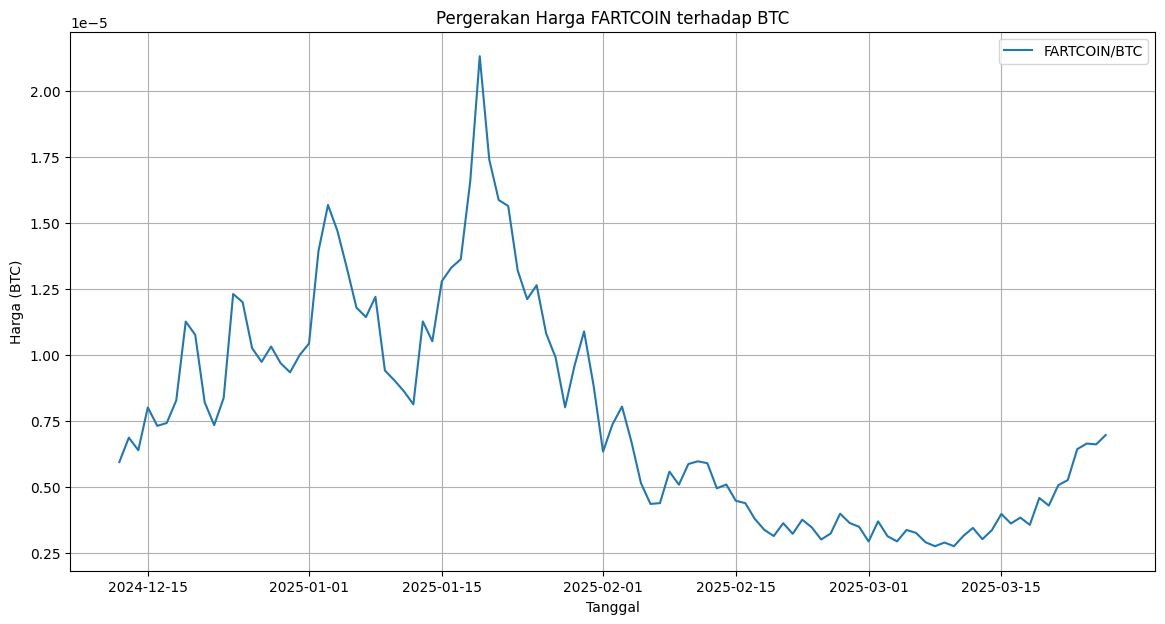

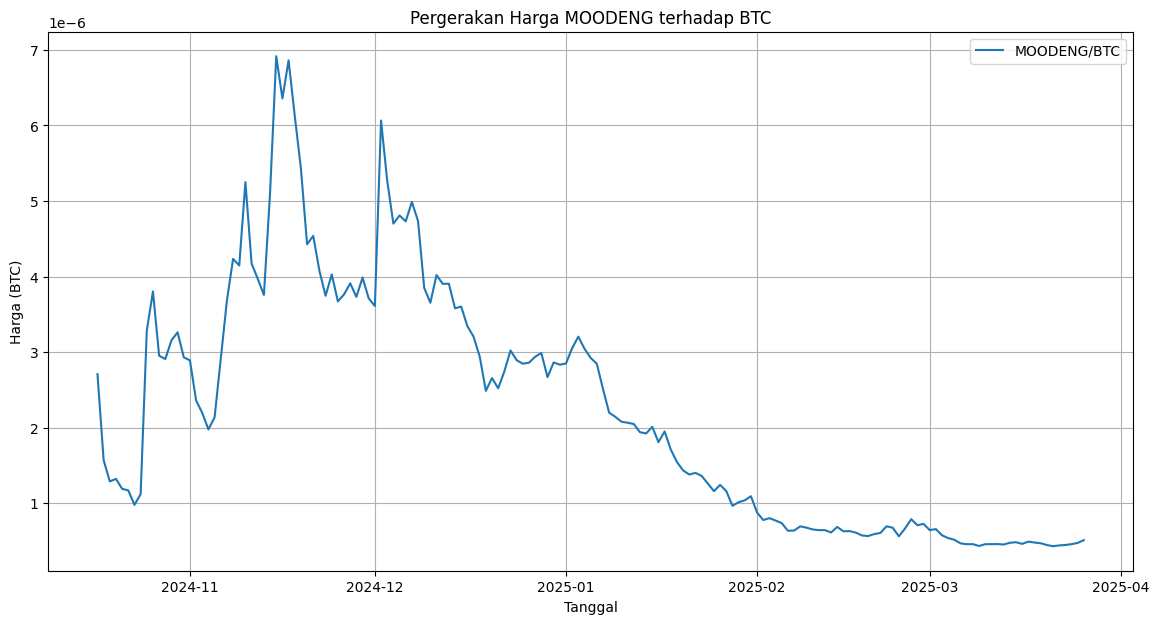

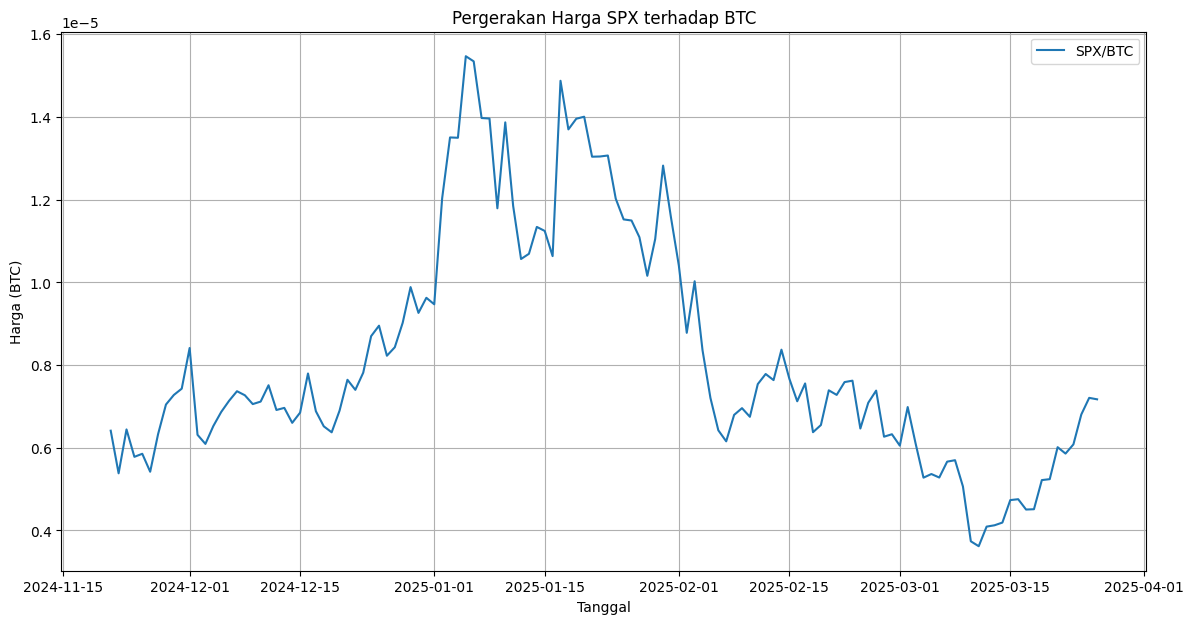

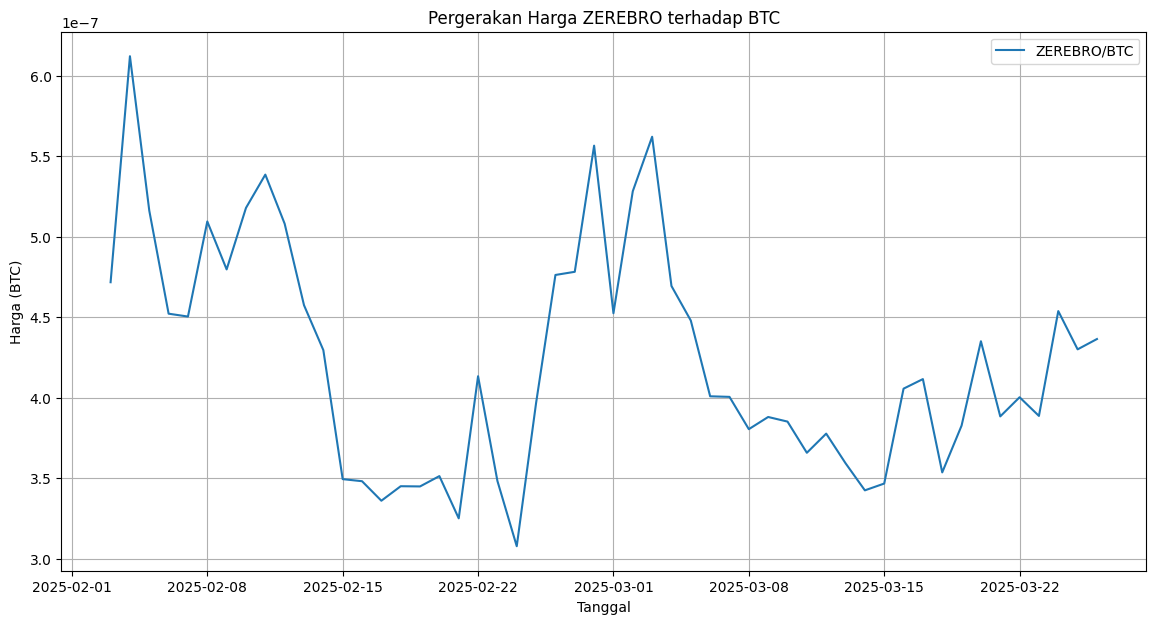

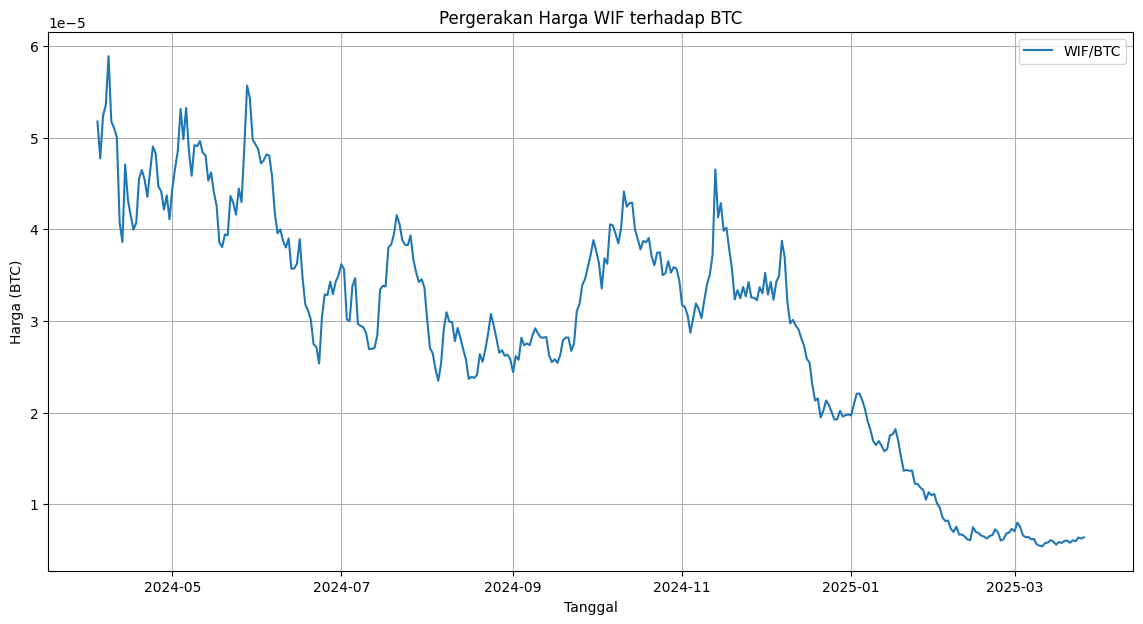

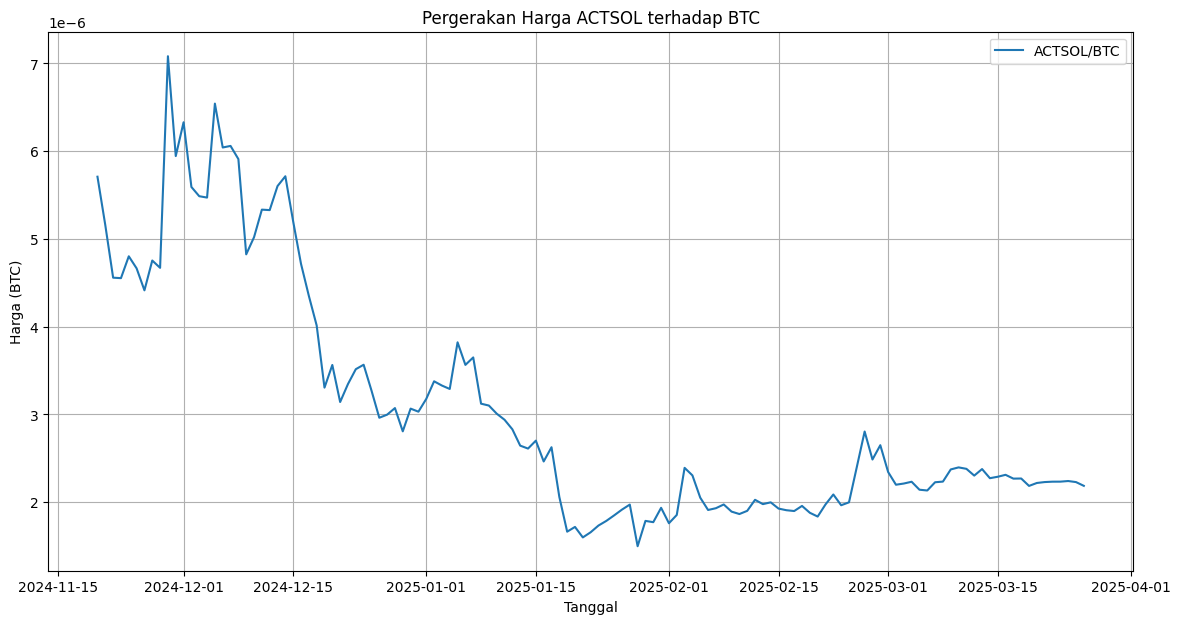

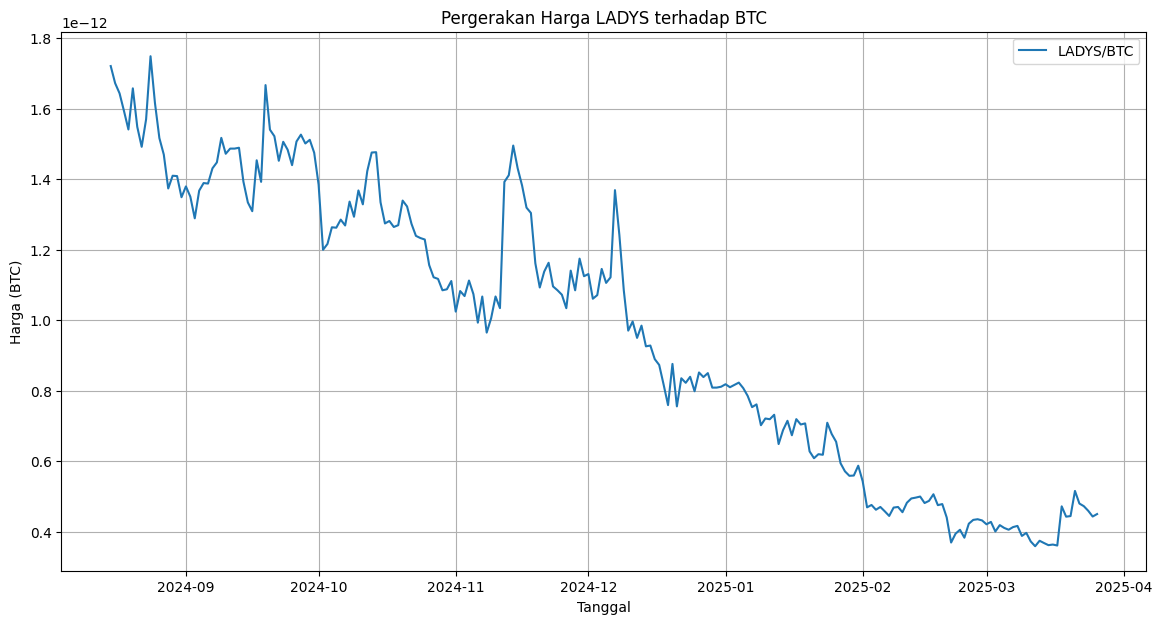

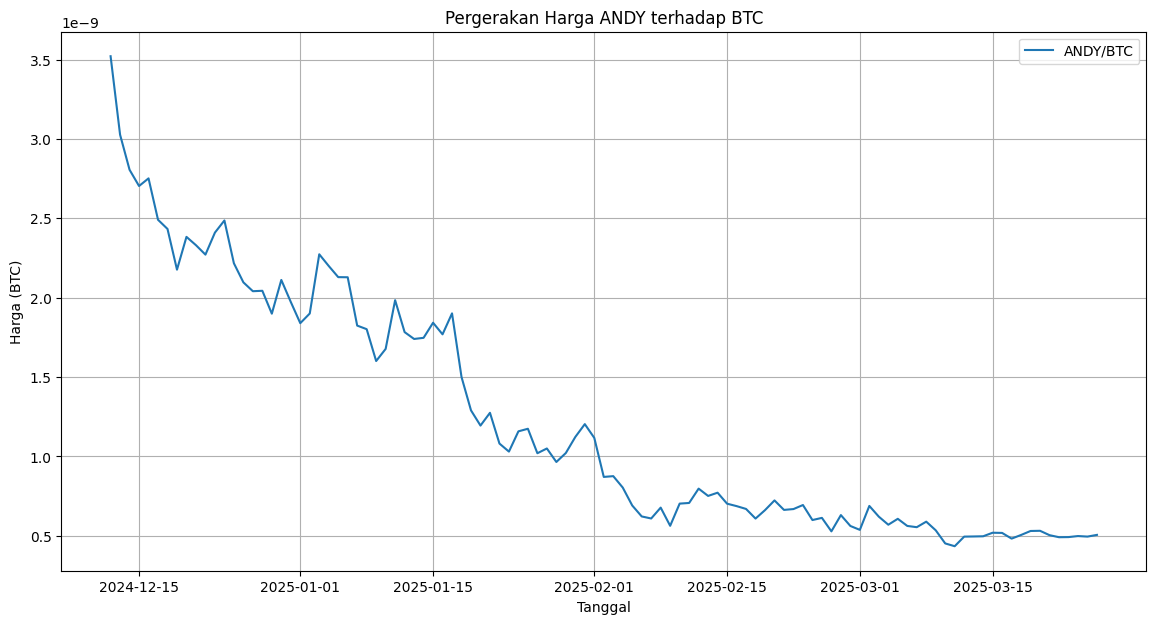

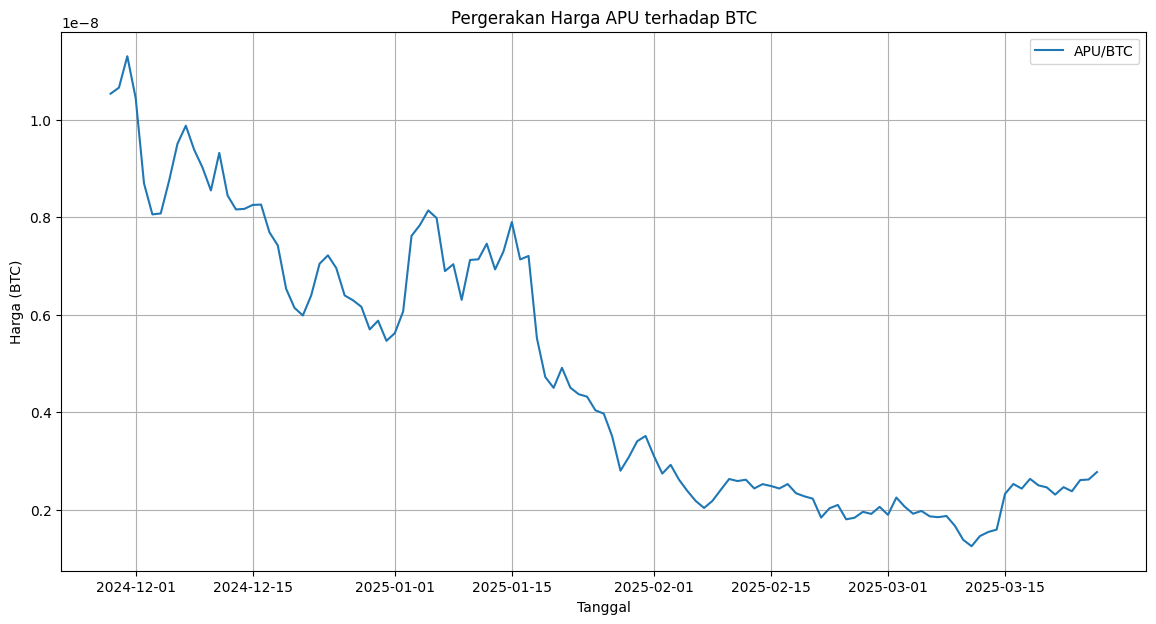

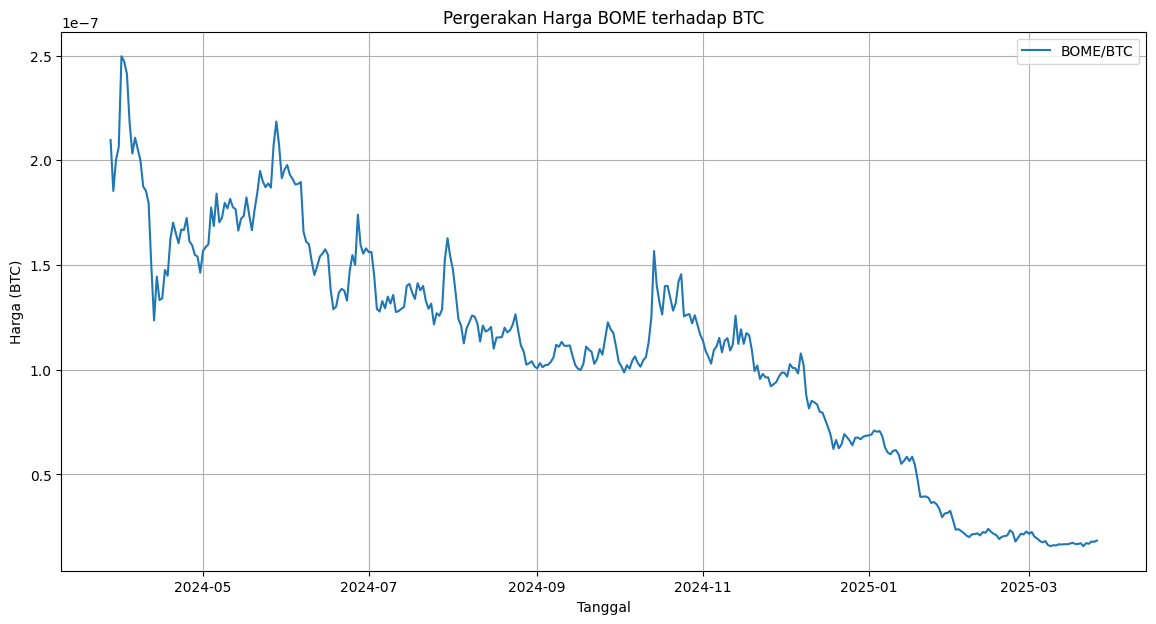

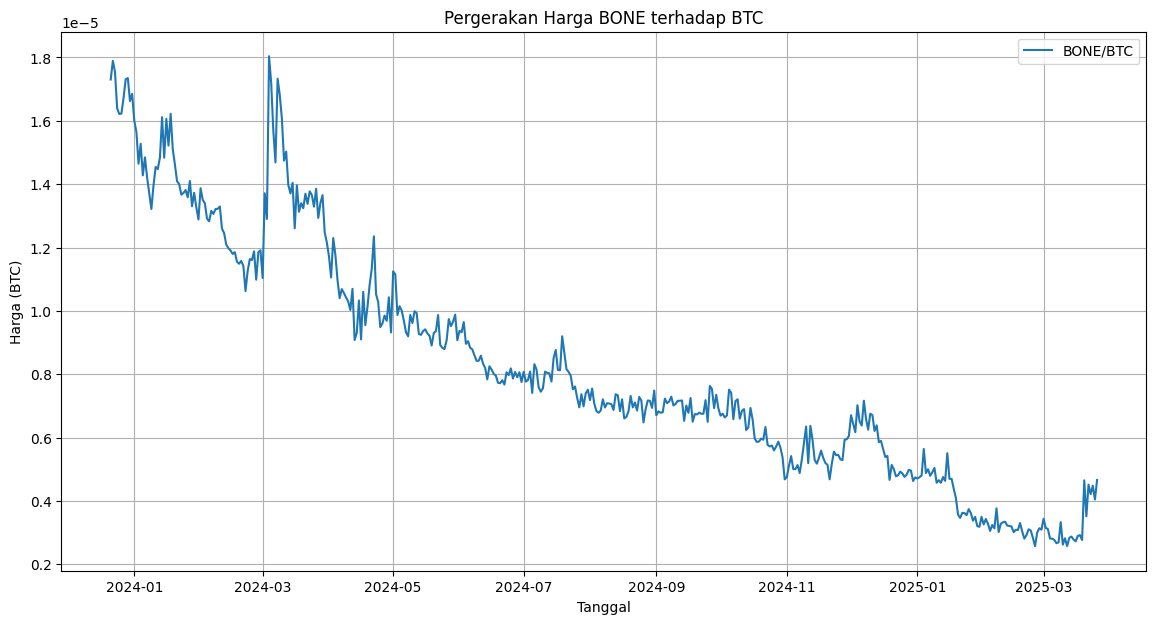

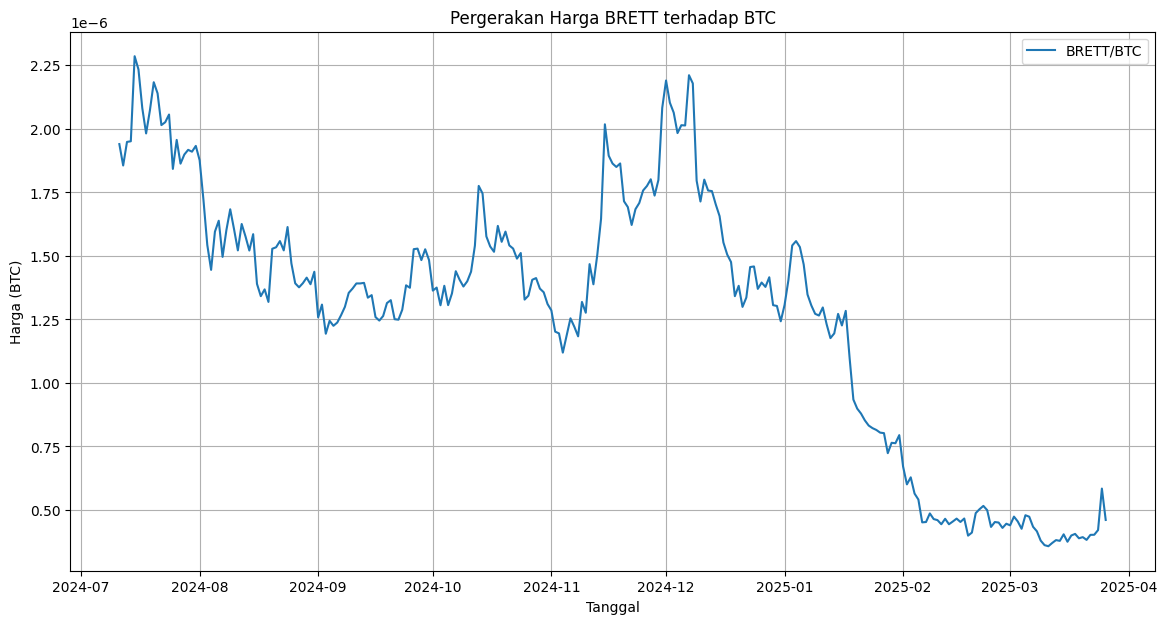

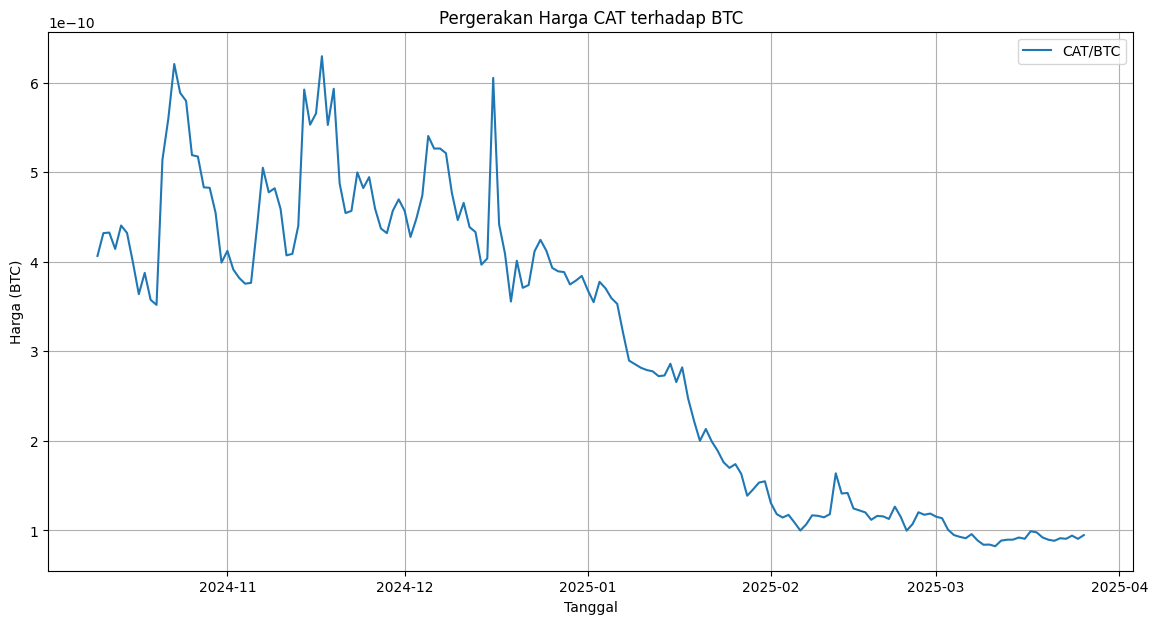

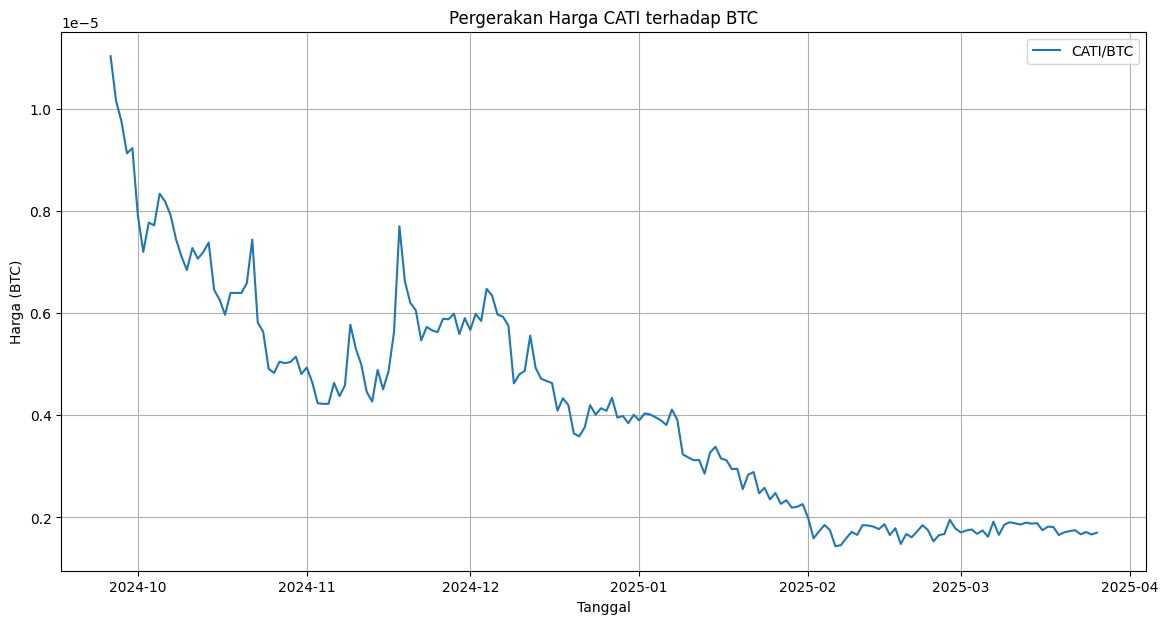

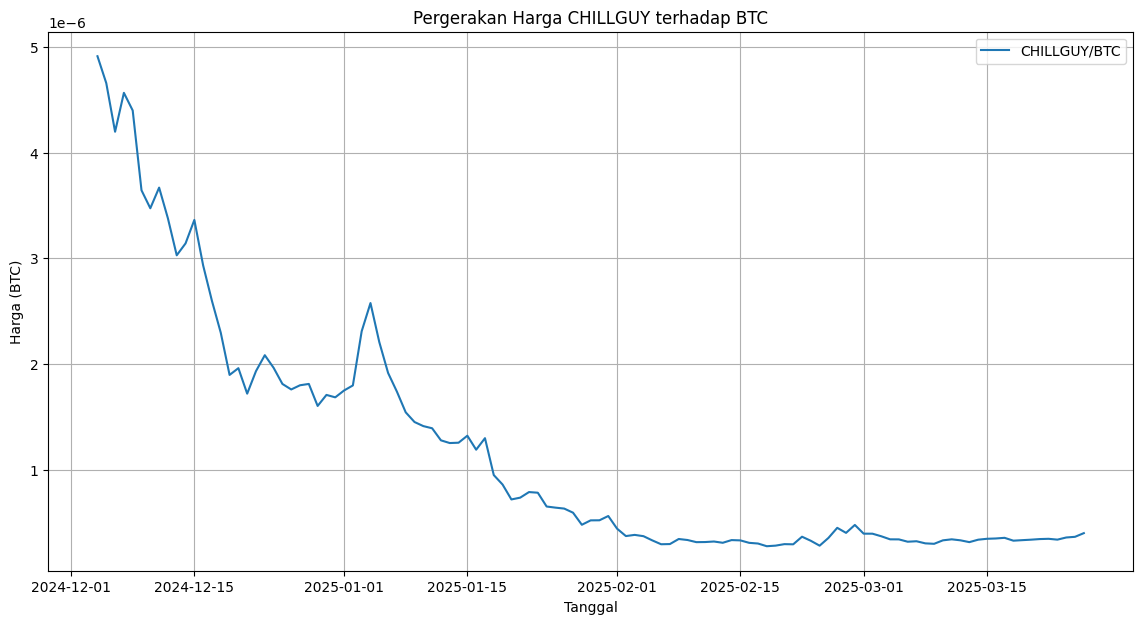

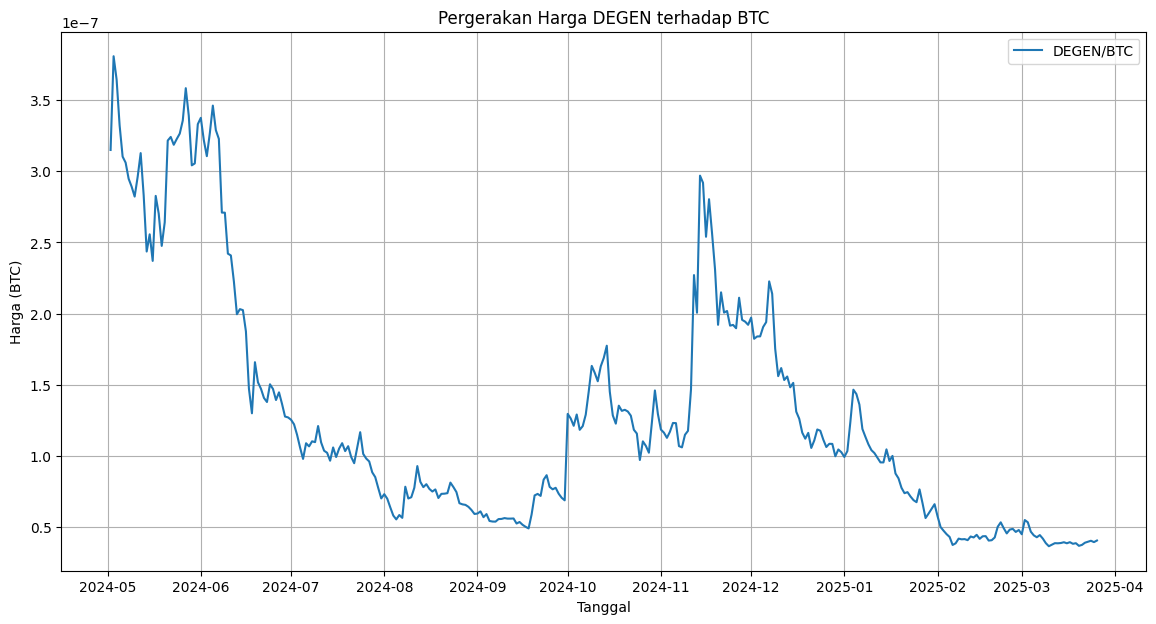

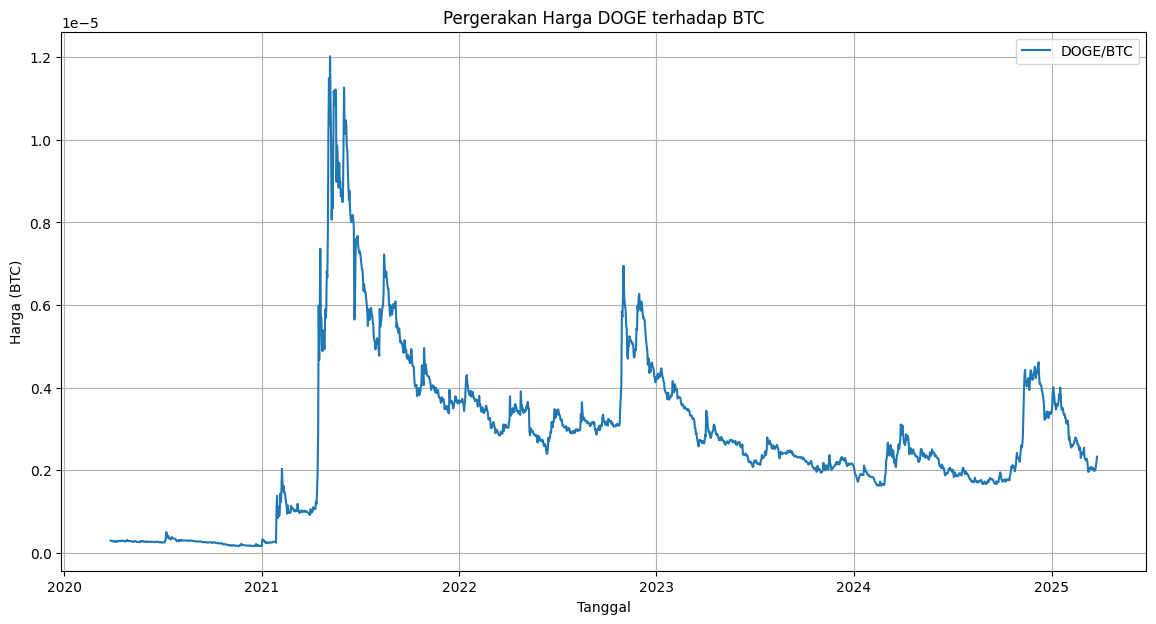

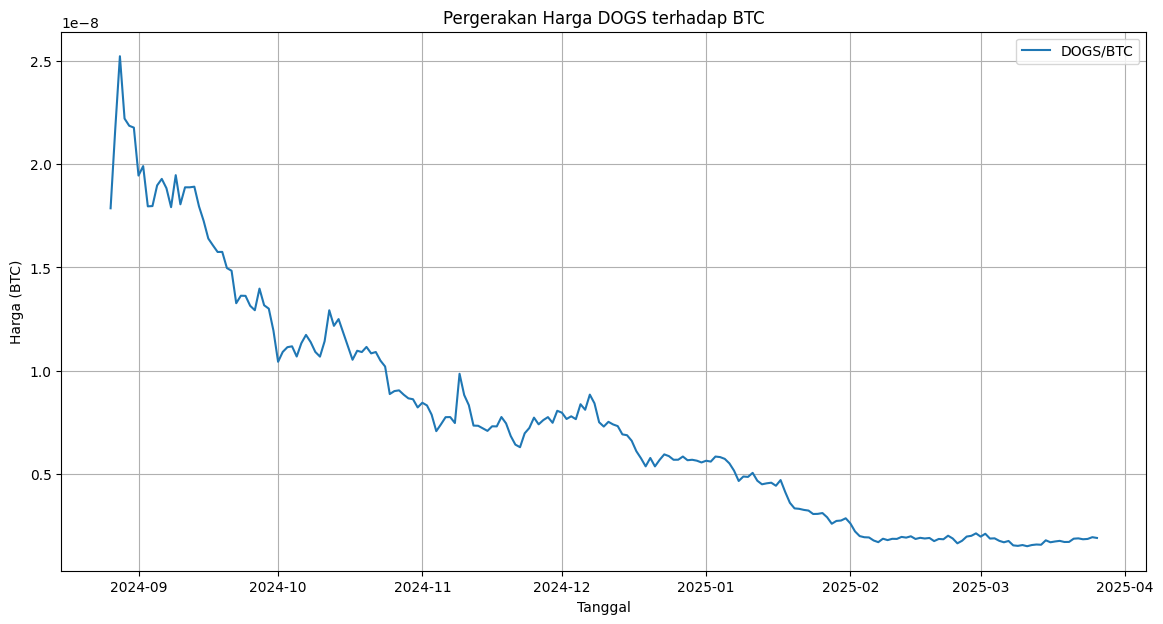

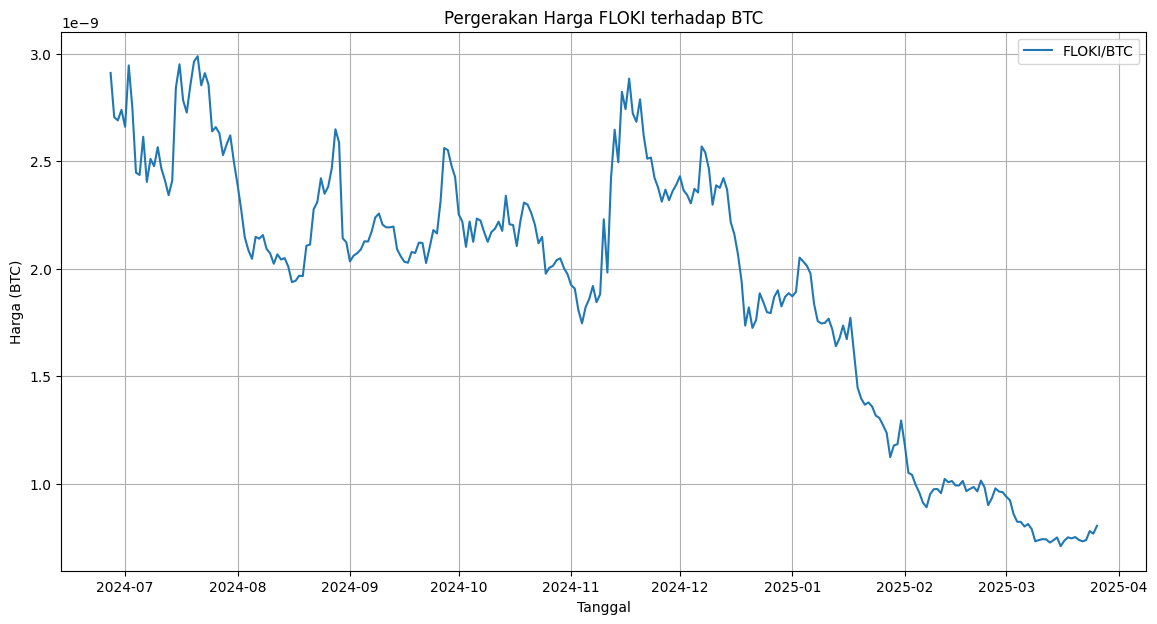

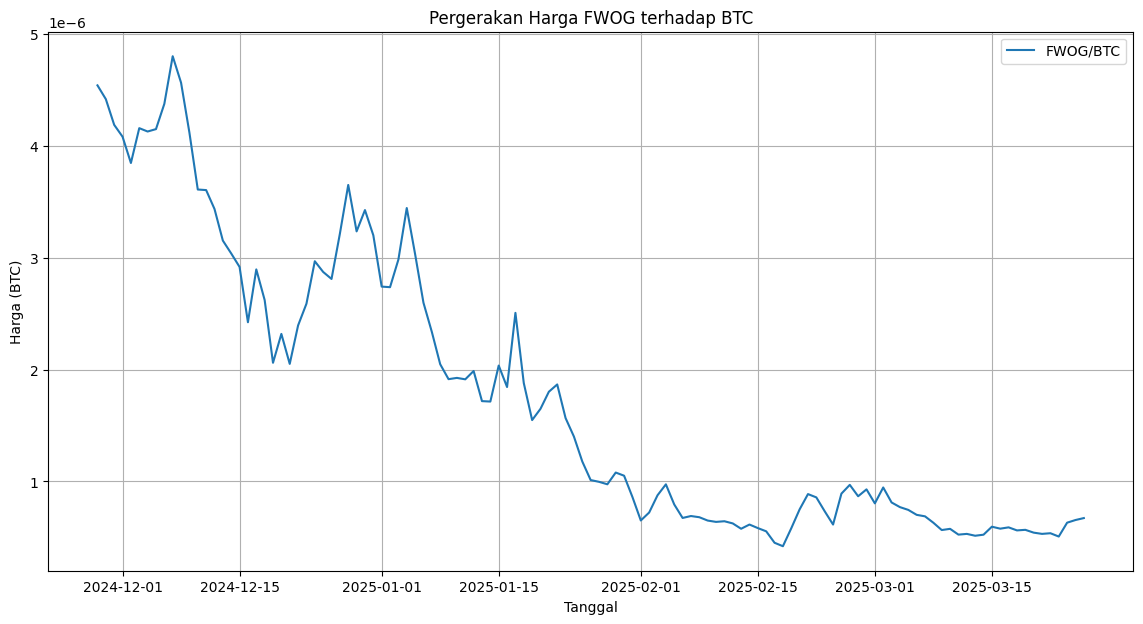

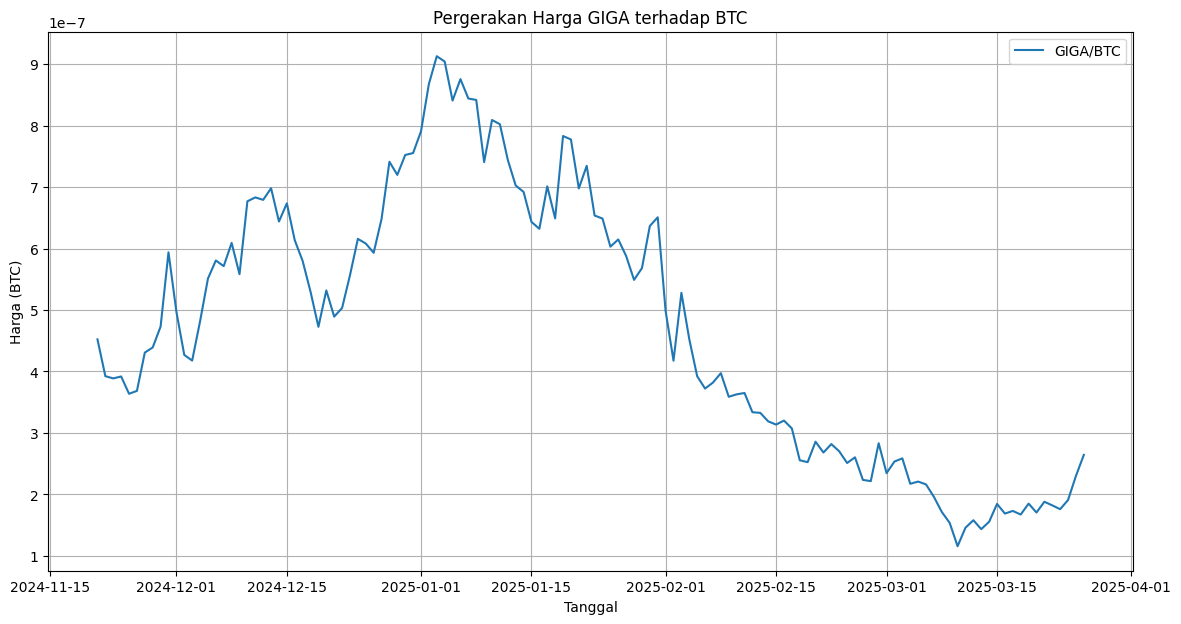

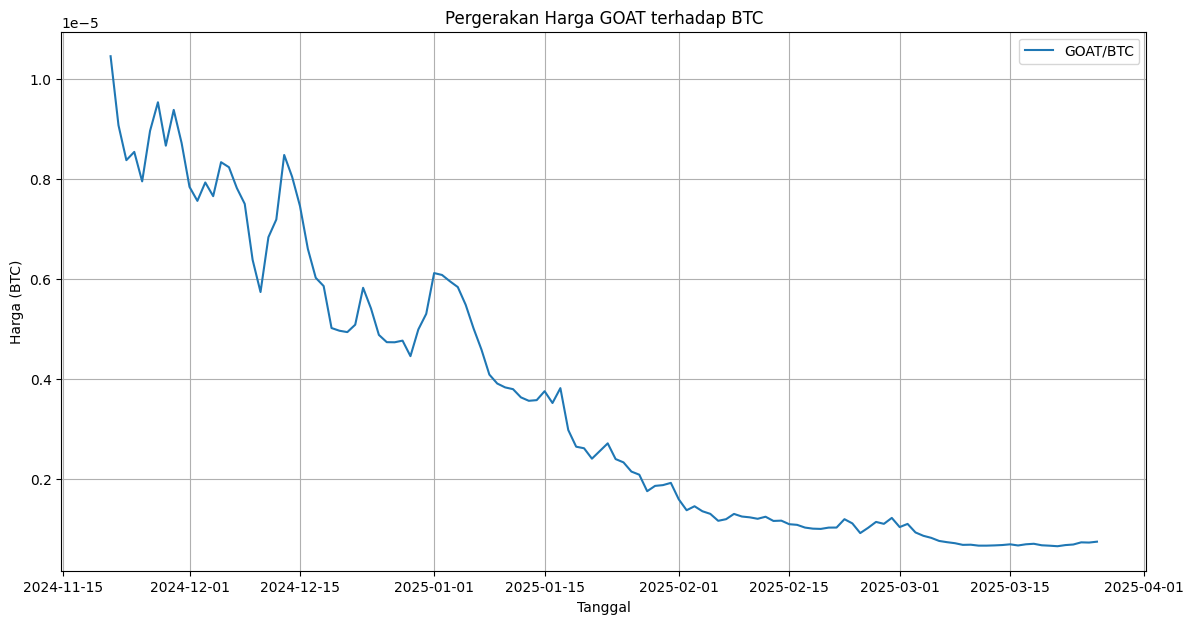

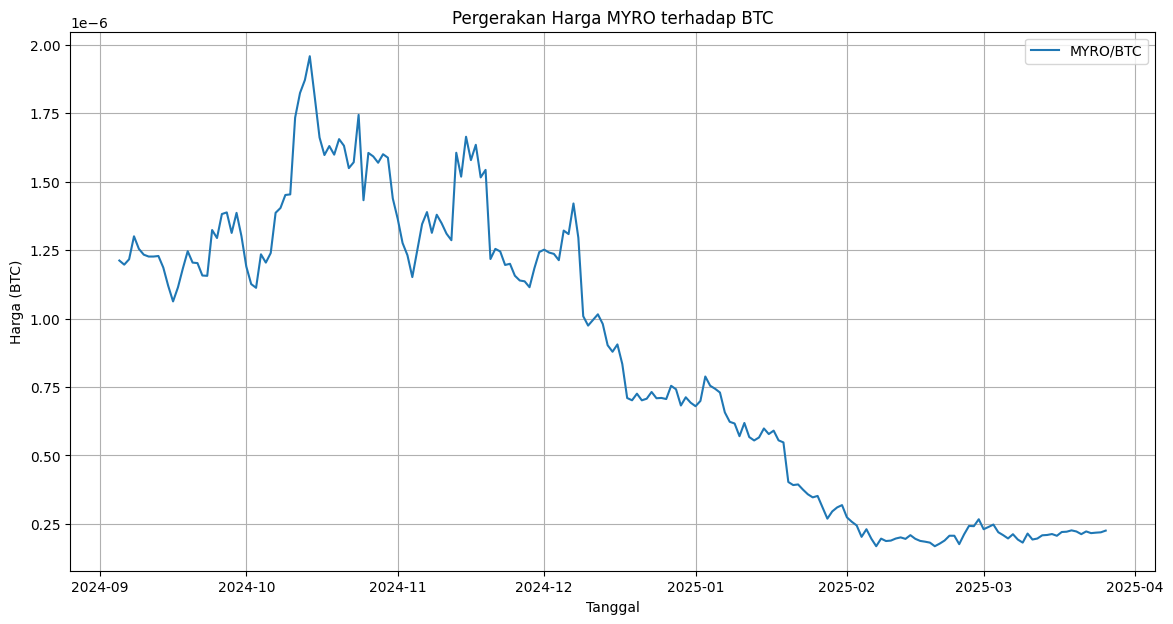

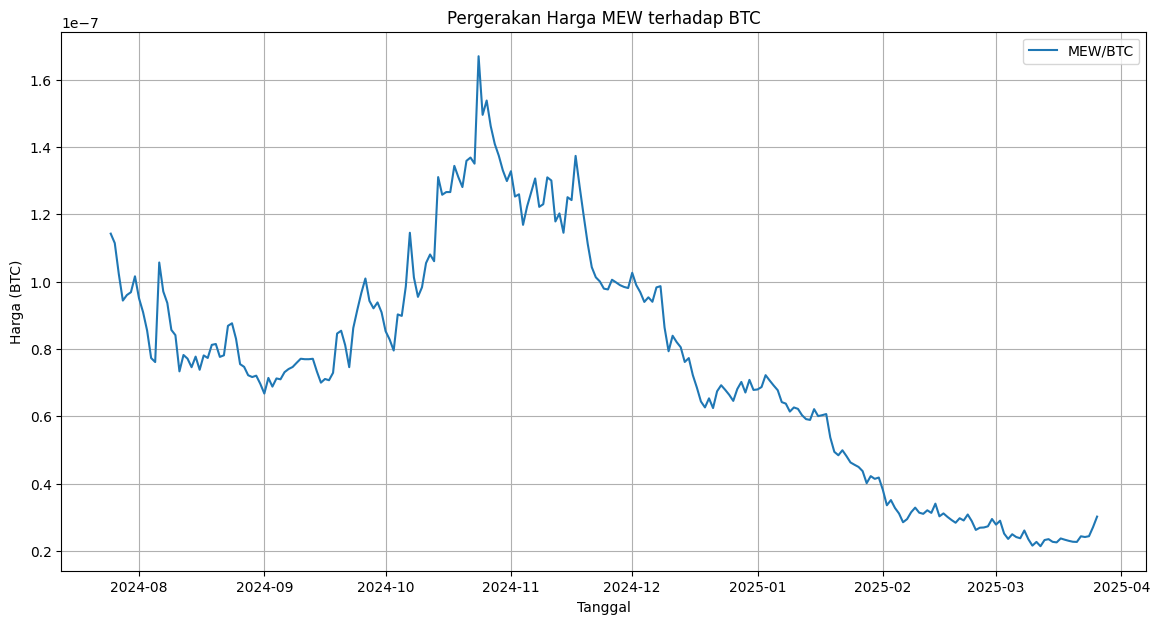

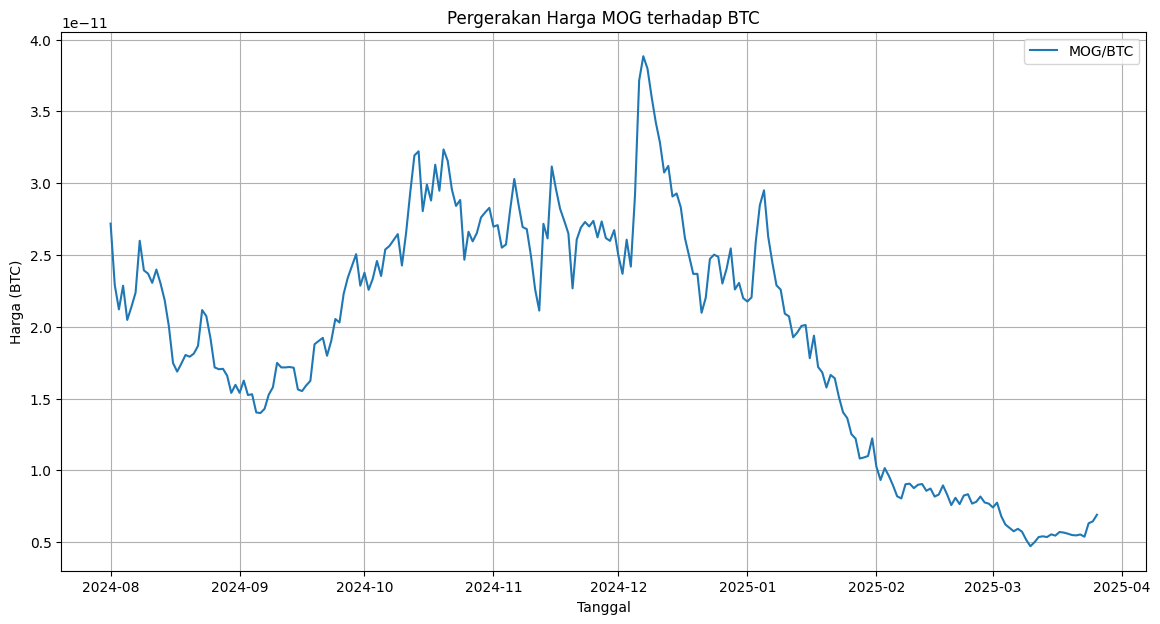

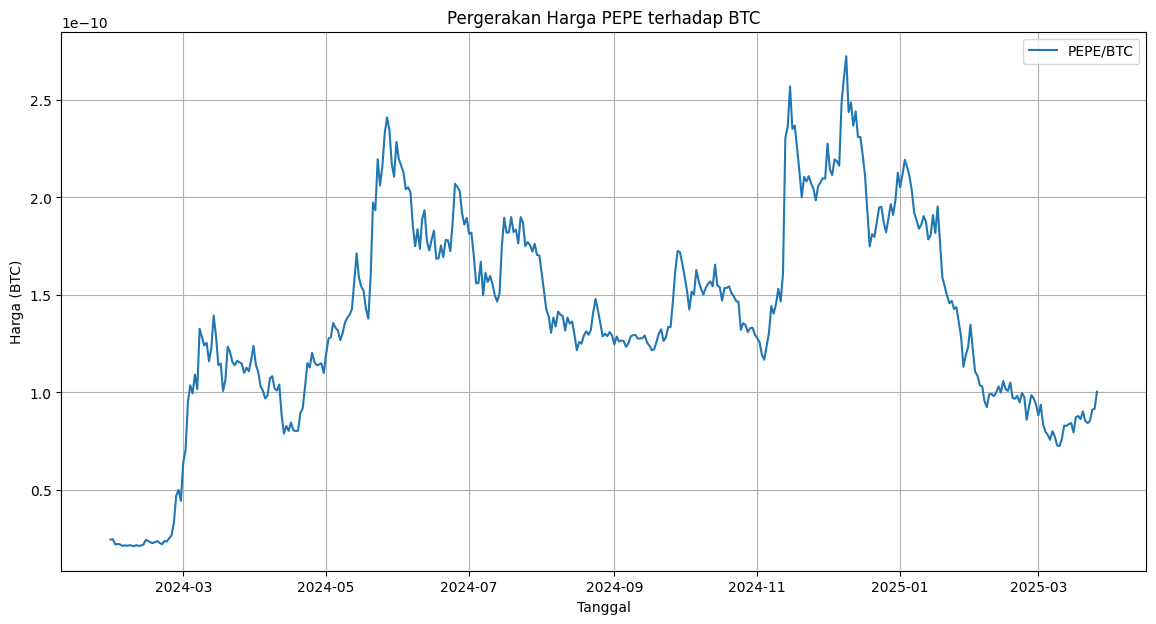

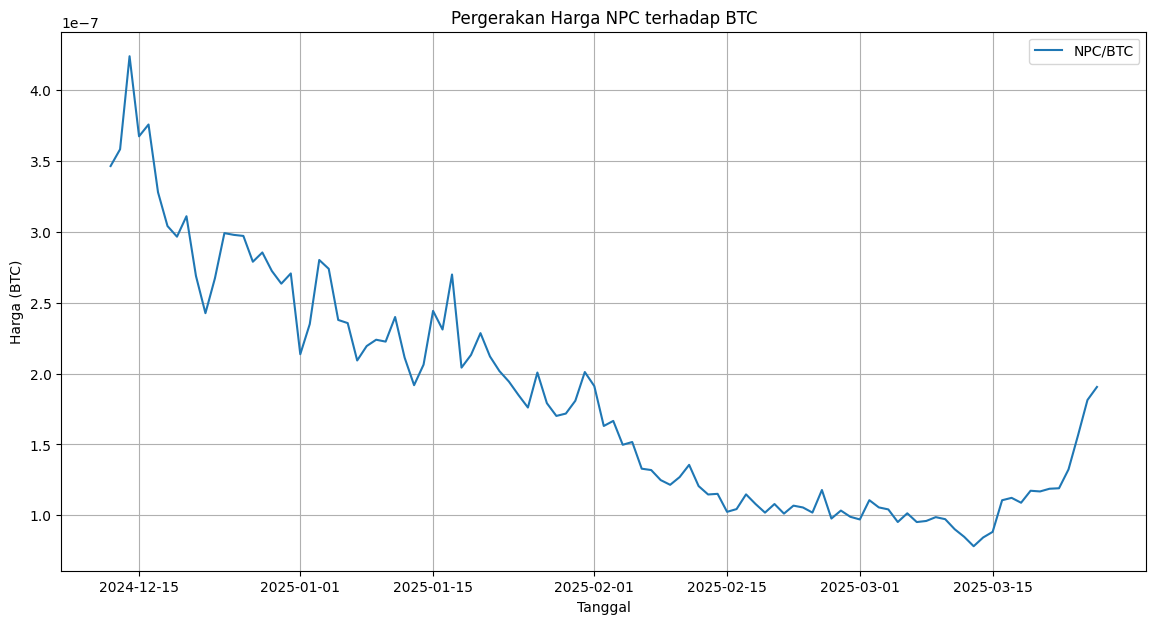

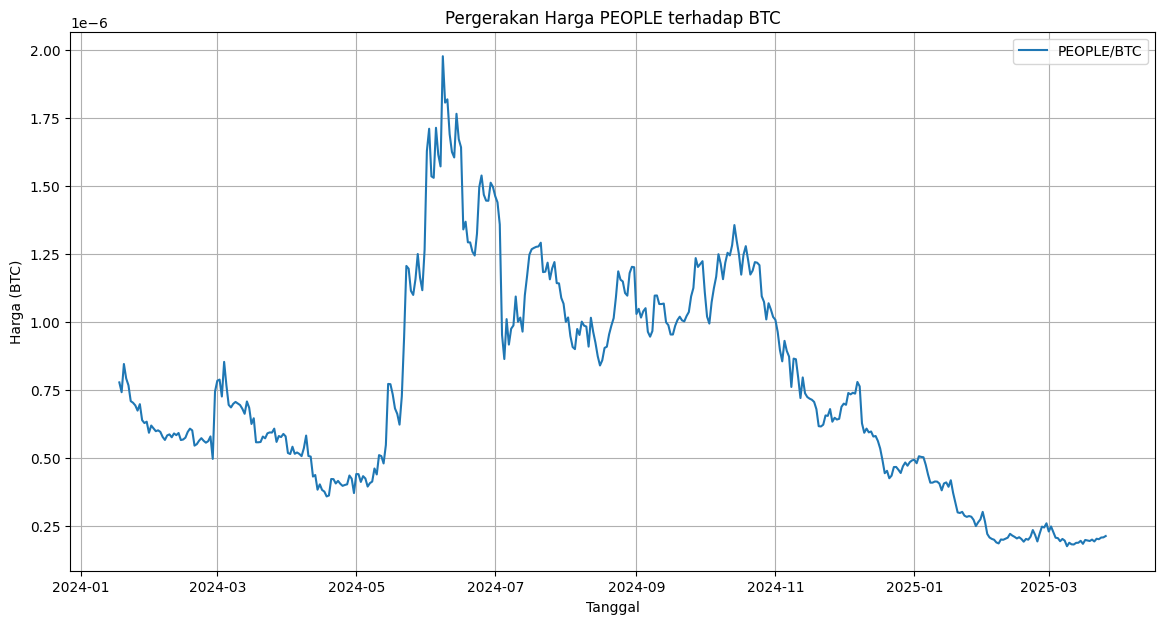

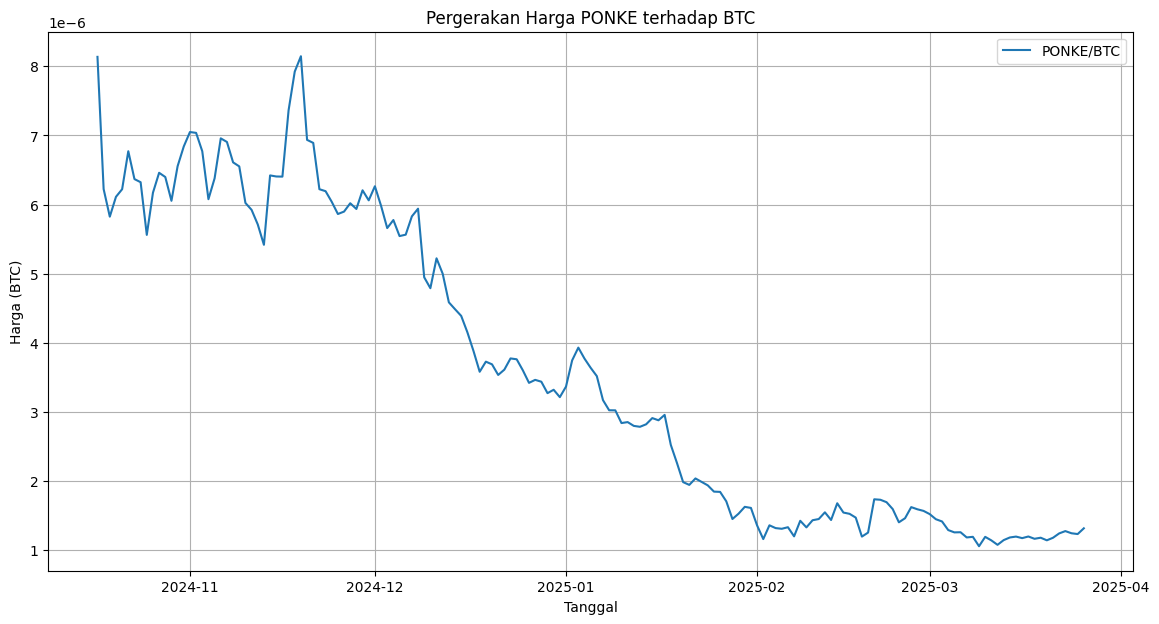

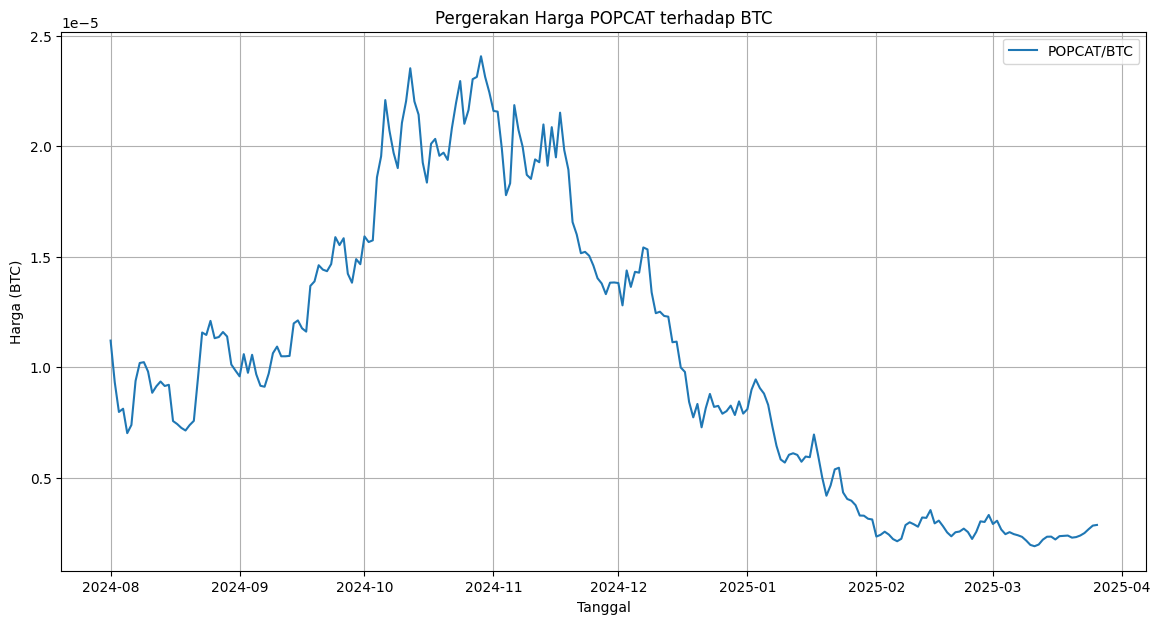

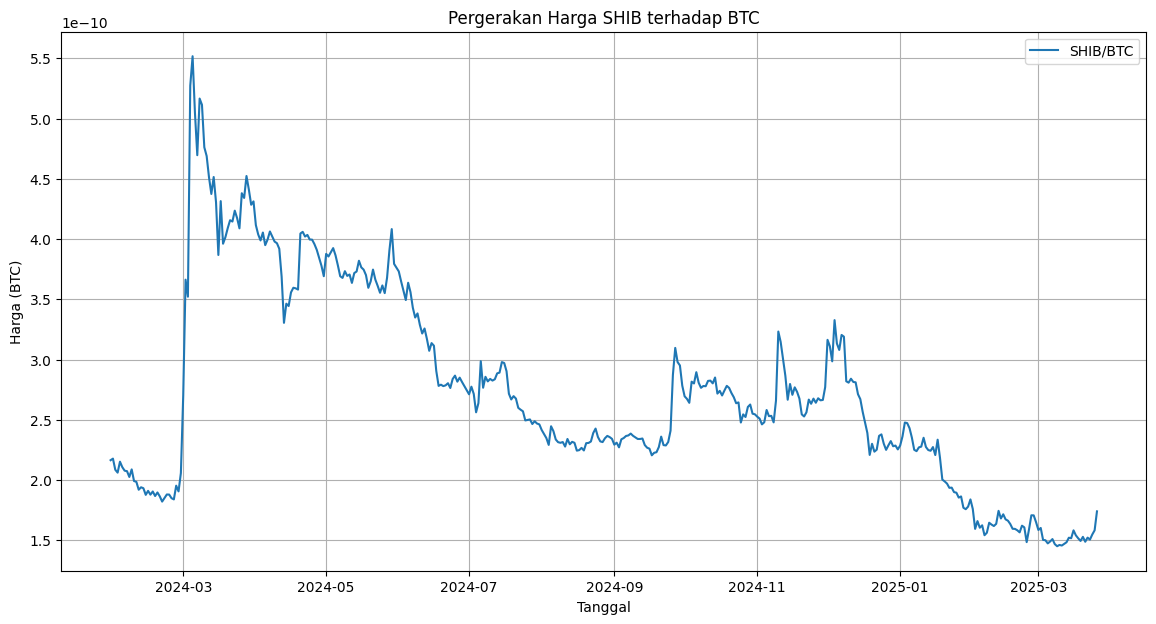

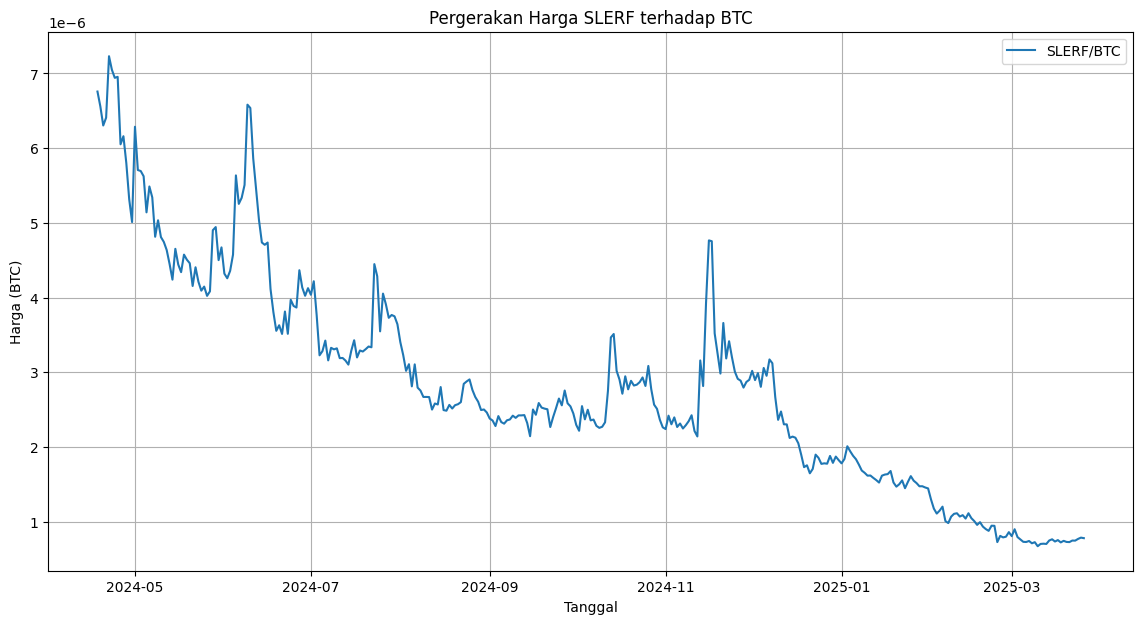

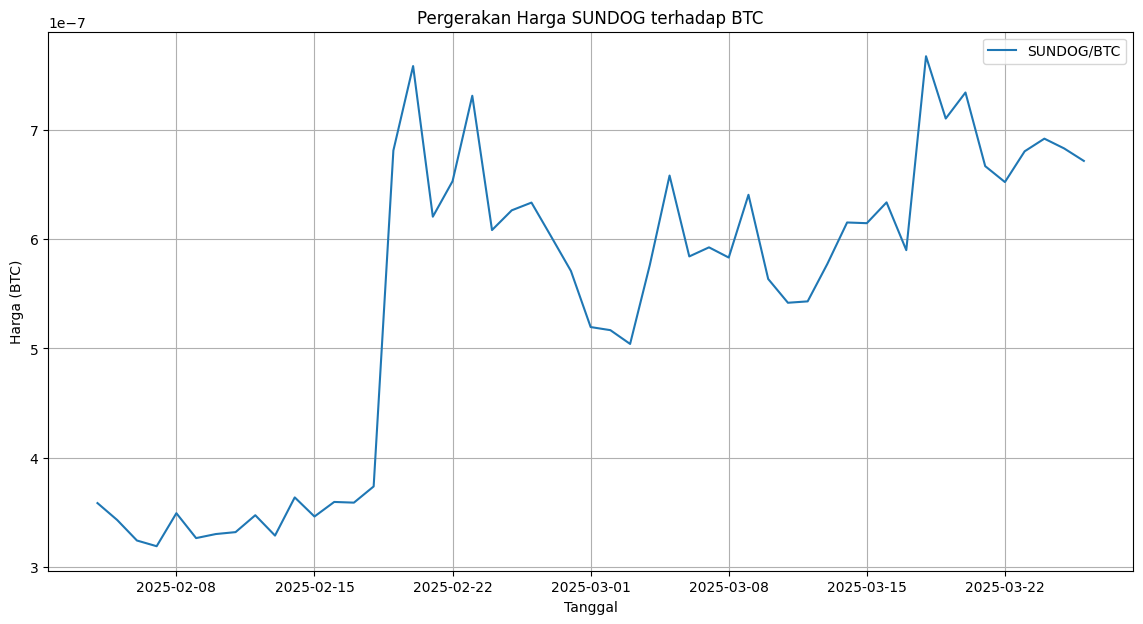

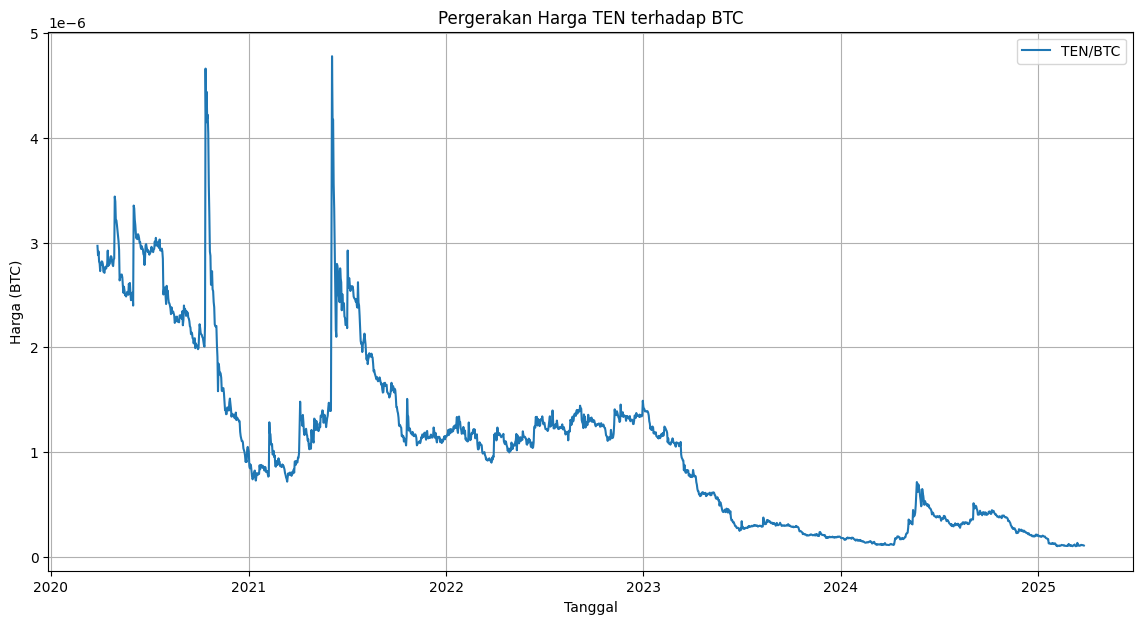

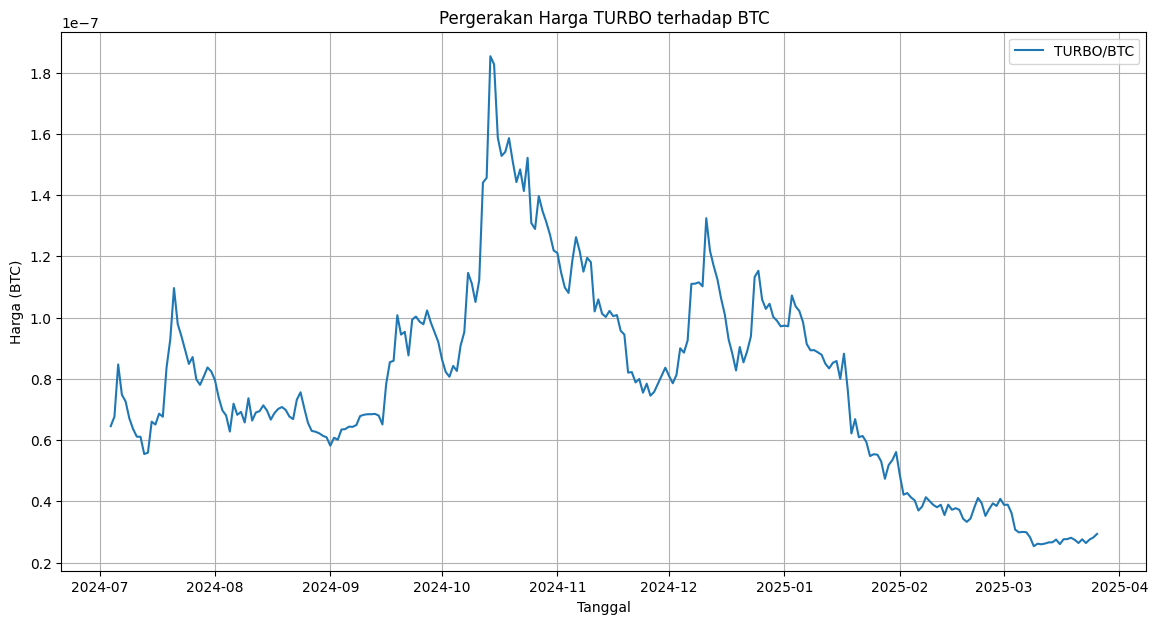

In [16]:
tickers = ['FARTCOIN', 'MOODENG', 'SPX', 'ZEREBRO', 'WIF', 'ACTSOL', 'LADYS', 'ANDY', 'APU', 'BOME', 'BONE', 'BRETT', 'CAT', 'CATI', 'CHILLGUY', 'DEGEN', 'DOGE', 'DOGS', 'FLOKI', 'FWOG', 'GIGA', 'GOAT', 'MYRO', 'MEW', 'MOG', 'PEPE', 'NPC', 'PEOPLE', 'PONKE', 'POPCAT', 'SHIB', 'SLERF', 'SUNDOG', 'TEN', 'TURBO']

tickers_error = ['NEIRO', 'VIRTUAL']

for i, ticker in enumerate(tickers) :
    show_chart(get_history_btc_pair(ticker, tf, timeFrom, timeTo, dfBtcIdr), ticker)